# Model training locally and in the cloud with the same code

In this notebook, we will train a simple model, first on our local machine, and then on AzureML, with the exact same code.

>> ADD BLURB ON THE DIFFERENT STEPS

### Library import

In [22]:
# For automatic reloading of modified libraries
%reload_ext autoreload
%autoreload 2

# Regular python libraries
from datetime import datetime
import json
import os
import papermill as pm
from sys import platform
from utils import *

from string import digits

# fast.ai
from fastai.vision import *
import torchvision.models as models

# Azure
import azureml.core
from azureml.core.conda_dependencies import CondaDependencies 

### Data retrieval

In this notebook, we will use the pets dataset provided by fast.ai.
All the images are stored in a single `images/` folder, and each image filename contains the image's label. We can then use fast.ai's `ImageDataBunch.from_name_re()` method to extract the images content and corresponding labels using a regular expression.
>> SEE IF WE WANT TO REPLACE IT BY SOMETHING ELSE

In [2]:
path = untar_data(URLs.PETS)
path_anno = path/'annotations'
path_img = path/'images'

In [3]:
print("> Data are now stored in {}".format(path))
print("> They are composed of: {}".format(path.ls()))

> Data are now stored in C:\Users\alteste\.fastai\data\oxford-iiit-pet
> They are composed of: [WindowsPath('C:/Users/alteste/.fastai/data/oxford-iiit-pet/annotations'), WindowsPath('C:/Users/alteste/.fastai/data/oxford-iiit-pet/images')]


In [4]:
# A few filename examples
fnames = get_image_files(path_img)
fnames[:5]

[WindowsPath('C:/Users/alteste/.fastai/data/oxford-iiit-pet/images/Abyssinian_1.jpg'),
 WindowsPath('C:/Users/alteste/.fastai/data/oxford-iiit-pet/images/Abyssinian_10.jpg'),
 WindowsPath('C:/Users/alteste/.fastai/data/oxford-iiit-pet/images/Abyssinian_100.jpg'),
 WindowsPath('C:/Users/alteste/.fastai/data/oxford-iiit-pet/images/Abyssinian_101.jpg'),
 WindowsPath('C:/Users/alteste/.fastai/data/oxford-iiit-pet/images/Abyssinian_102.jpg')]

Images are in stored in alphabetical order. For proper training, it is important to shuffle them, and to use a random seed for it.

In [5]:
pattern = r'/([^/]+)_\d+.jpg$'

# The filenames are of the form:
# - starts with a forward slash,
# - is followed by many characters that are not forward slashes
# - then followed by an underscore and one or more digits
# - has a ".jpg" extension

In [6]:
# By default, fast.ai uses batch sizes of 64 images
# Here, we are using batches of 16 to ensure that we have enough memory to process the data

# We load the data and parse the labels from the image filenames
# We transform the images such that they now have a 224x224 shape

new_batch_size = 16
data = ImageDataBunch.from_name_re(path=path_img, fnames=fnames, pat=pattern, 
                                   ds_tfms=get_transforms(), size=224, 
                                   bs=new_batch_size).normalize(imagenet_stats)

In [7]:
data.train_ds

LabelList (5912 items)
x: ImageItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Abyssinian,Abyssinian,Abyssinian,Abyssinian,Abyssinian
Path: C:\Users\alteste\.fastai\data\oxford-iiit-pet\images

In [8]:
print(data.classes)
print(len(data.classes))

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']
37


This dataset contains 5912 images, grouped into 37 classes. These images have now been transformed to have a 224x224 shape. The figure below shows a few examples of them.

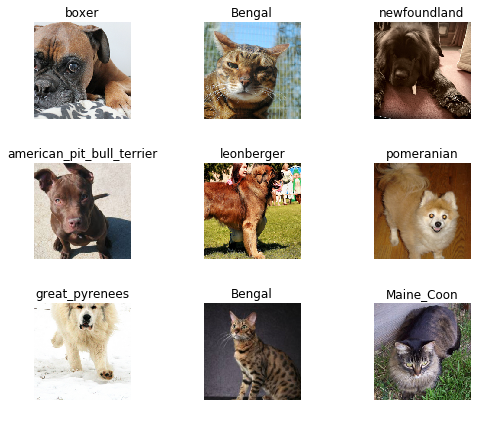

In [9]:
data.show_batch(rows=3, figsize=(7,6))

### Model training - Locally

Here, we use resnet34, i.e. a [residual neural network](https://arxiv.org/pdf/1512.03385.pdf) that contains 34 hidden layers, and leverage the [default settings](https://pytorch.org/docs/stable/torchvision/models.html#id3) implemented by Pytorch.

In [12]:
mdl_object = models.resnet34 # any model among alexnet, resnet18/34/50/101/152, squeezenet1.0/1.1, densenet121/161/169/201, vgg16/19

if platform == 'win32':
    learn = custom_create_cnn(data, mdl_object, metrics=error_rate)
else:
    learn = create_cnn(data, mdl_object, metrics=error_rate)

Model *resnet34* is using 1024 features


In [13]:
print(datetime.now())
learn.fit_one_cycle(4)  # This typically takes ~ 2h15min on a CPU

2019-02-28 11:54:58.671448


epoch,train_loss,valid_loss,error_rate
1,0.704117,0.370206,0.117050
2,0.580521,0.303932,0.089986
3,0.398737,0.238415,0.076455
4,0.328578,0.225804,0.068336


Training this model on a single CPU machine typically takes about 2h15min.

In [14]:
interp = ClassificationInterpretation.from_learner(learn)

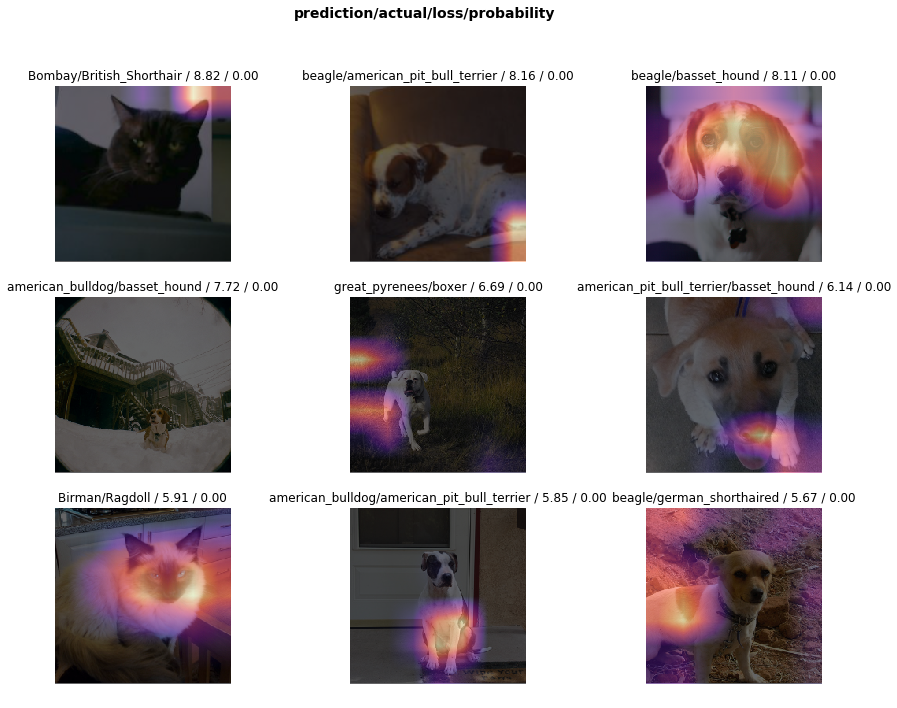

In [15]:
interp.plot_top_losses(9, figsize=(15,11))

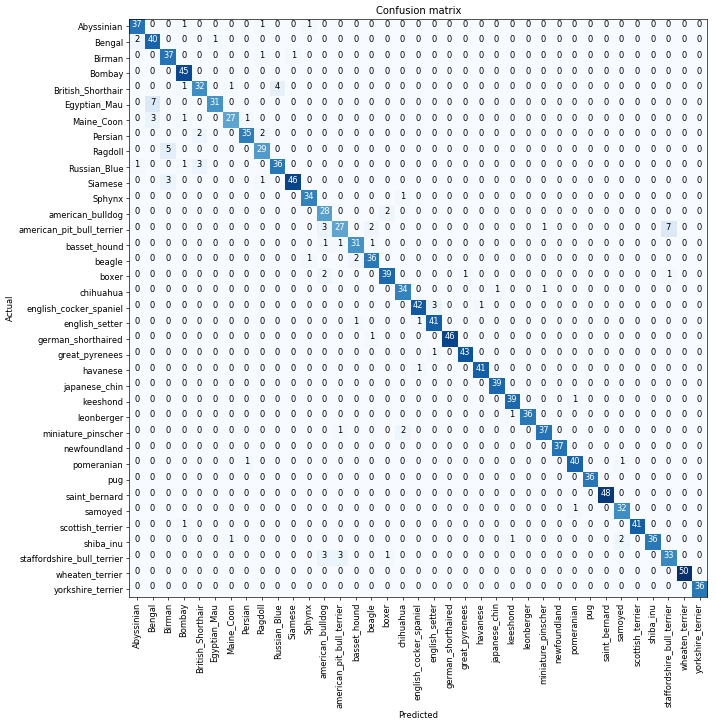

In [16]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [17]:
interp.most_confused(min_val=2)

[('Egyptian_Mau', 'Bengal', 7),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 7),
 ('Ragdoll', 'Birman', 5),
 ('British_Shorthair', 'Russian_Blue', 4),
 ('Maine_Coon', 'Bengal', 3),
 ('Russian_Blue', 'British_Shorthair', 3),
 ('Siamese', 'Birman', 3),
 ('american_pit_bull_terrier', 'american_bulldog', 3),
 ('english_cocker_spaniel', 'english_setter', 3),
 ('staffordshire_bull_terrier', 'american_bulldog', 3),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 3),
 ('Bengal', 'Abyssinian', 2),
 ('Persian', 'British_Shorthair', 2),
 ('Persian', 'Ragdoll', 2),
 ('american_bulldog', 'boxer', 2),
 ('american_pit_bull_terrier', 'beagle', 2),
 ('beagle', 'basset_hound', 2),
 ('boxer', 'american_bulldog', 2),
 ('miniature_pinscher', 'chihuahua', 2),
 ('shiba_inu', 'samoyed', 2)]

In [18]:
output_folder = os.getcwd() + '/outputs/'
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

learn.export(output_folder + 'image_classif_model_cats_dogs.pkl')

In [23]:
#Record of the model metrics, so they are accessible when this notebook gets run remotely
training_losses = [x.numpy().ravel()[0] for x in learn.recorder.losses]
accuracy_list = [x[0].numpy().ravel()[0] for x in learn.recorder.metrics]

pm.record('training_loss', training_losses)
pm.record('validation_loss', learn.recorder.val_losses)
pm.record('accuracy', accuracy_list)
pm.record('learning_rate', learn.recorder.lrs)

Min numerical gradient: 1.25E-04


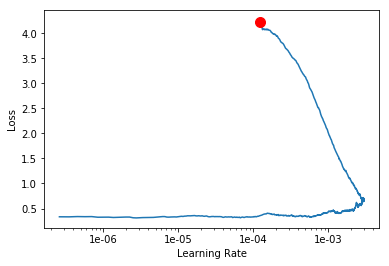

In [20]:
learn.recorder.plot()

Now that we have trained our model on our local machine, let's reuse this same notebook and launch its execution on AzureML. For this, we will use the Launch_notebook_on_AzureML.ipynb notebook. << ADD LINK HERE >>

In [ ]:
#Reference notebook: https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson1-pets.ipynb